In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data1 = pd.read_pickle('Building-1-Roulart Media Group/building_1_cnsumptions.pkl')
data1.index = pd.to_datetime(data1.index)
data1['Datetime'] = data1.index
data1

,Valeur,Datetime
Date,,
2014-01-06 02:00:00,6.51,2014-01-06 02:00:00
2014-01-06 02:15:00,6.51,2014-01-06 02:15:00
2014-01-06 02:30:00,6.72,2014-01-06 02:30:00
2014-01-06 02:45:00,6.51,2014-01-06 02:45:00
2014-01-06 03:00:00,6.93,2014-01-06 03:00:00
...,...,...
2020-06-30 23:00:00,5.04,2020-06-30 23:00:00
2020-06-30 23:15:00,3.36,2020-06-30 23:15:00
2020-06-30 23:30:00,3.36,2020-06-30 23:30:00


In [3]:
# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
data1 = data1.groupby('Datetime', as_index=False)['Valeur'].mean()

# Sorting the values
data1.sort_values('Datetime', inplace=True)
data1.head()

,Datetime,Valeur
0,2014-01-06 02:00:00,6.51
1,2014-01-06 02:15:00,6.51
2,2014-01-06 02:30:00,6.72
3,2014-01-06 02:45:00,6.51
4,2014-01-06 03:00:00,6.93


In [4]:
# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

Using TensorFlow backend.


In [5]:
deep_learner = DeepModelTS(
data = data1,
Y_var = 'Valeur',
lag = 34,
LSTM_layer_depth = 50,
epochs = 30,
batch_size = 200,
train_test_split = 0.15
)

In [ ]:
# Fitting the model
model = deep_learner.LSTModel()

Train on 181260 samples, validate on 31987 samples
Epoch 1/30


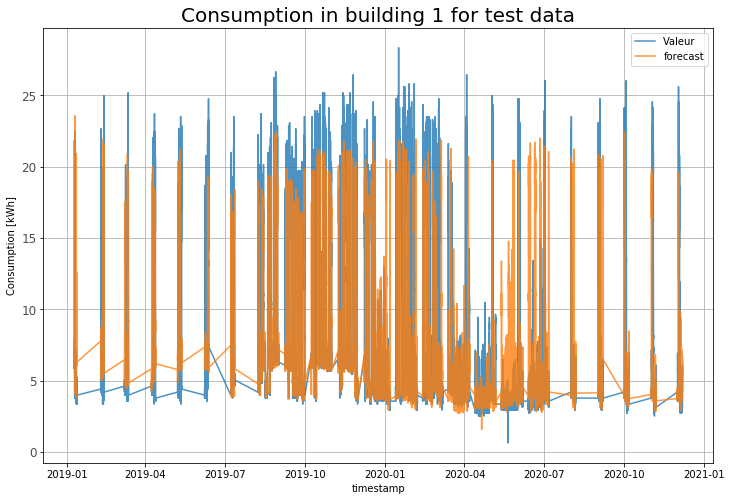

In [213]:
yhat = deep_learner.predict()# Constructing the forecast dataframe
fc = data1.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
fc.sort_values('Datetime', inplace=True)
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc,label=dtype,alpha=0.8)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()

In [76]:
aheaddeep_learner = DeepModelTS(
data=data1,
Y_var='Valeur',
lag = 34,
LSTM_layer_depth = 50,
epochs = 30,
train_test_split = 0
)

# Fitting the model
deep_learner.LSTModel()

# Forecasting n steps ahead
n_ahead = 96

yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Train on 181260 samples, validate on 31987 samples
Epoch 1/30
181260/181260 [==============================] - 307s 2ms/step - loss: 13.5628 - val_loss: 1.2941
Epoch 2/30
181260/181260 [==============================] - 245s 1ms/step - loss: 1.8465 - val_loss: 1.3661
Epoch 3/30
181260/181260 [==============================] - 230s 1ms/step - loss: 1.7623 - val_loss: 1.2393
Epoch 4/30
181260/181260 [==============================] - 293s 2ms/step - loss: 1.7118 - val_loss: 1.1805
Epoch 5/30
181260/181260 [==============================] - 235s 1ms/step - loss: 1.6853 - val_loss: 1.1691
Epoch 6/30
181260/181260 [==============================] - 236s 1ms/step - loss: 1.6690 - val_loss: 1.1476
Epoch 7/30
181260/181260 [==============================] - 238s 1ms/step - loss: 1.6568 - val_loss: 1.1342
Epoch 8/30
181260/181260 [==============================] - 238s 1ms/step - loss: 1.6489 - val_loss: 1.1245
Epoch 9/30
181260/181260 [==============================] - 284s 2ms/step - loss: 1.

In [218]:
fc = fc.set_index('Date')
fc.index = pd.to_datetime(fc.index)
fc.head()

,Valeur,Datetime,forecast
Date,,,
2019-01-09 00:00:00,6.93,2019-01-09 00:00:00,7.500196
2019-01-09 00:15:00,6.51,2019-01-09 00:15:00,6.942563
2019-01-09 00:30:00,6.30,2019-01-09 00:30:00,6.740320
2019-01-09 00:45:00,6.51,2019-01-09 00:45:00,6.342435
2019-01-09 01:00:00,6.30,2019-01-09 01:00:00,6.353085


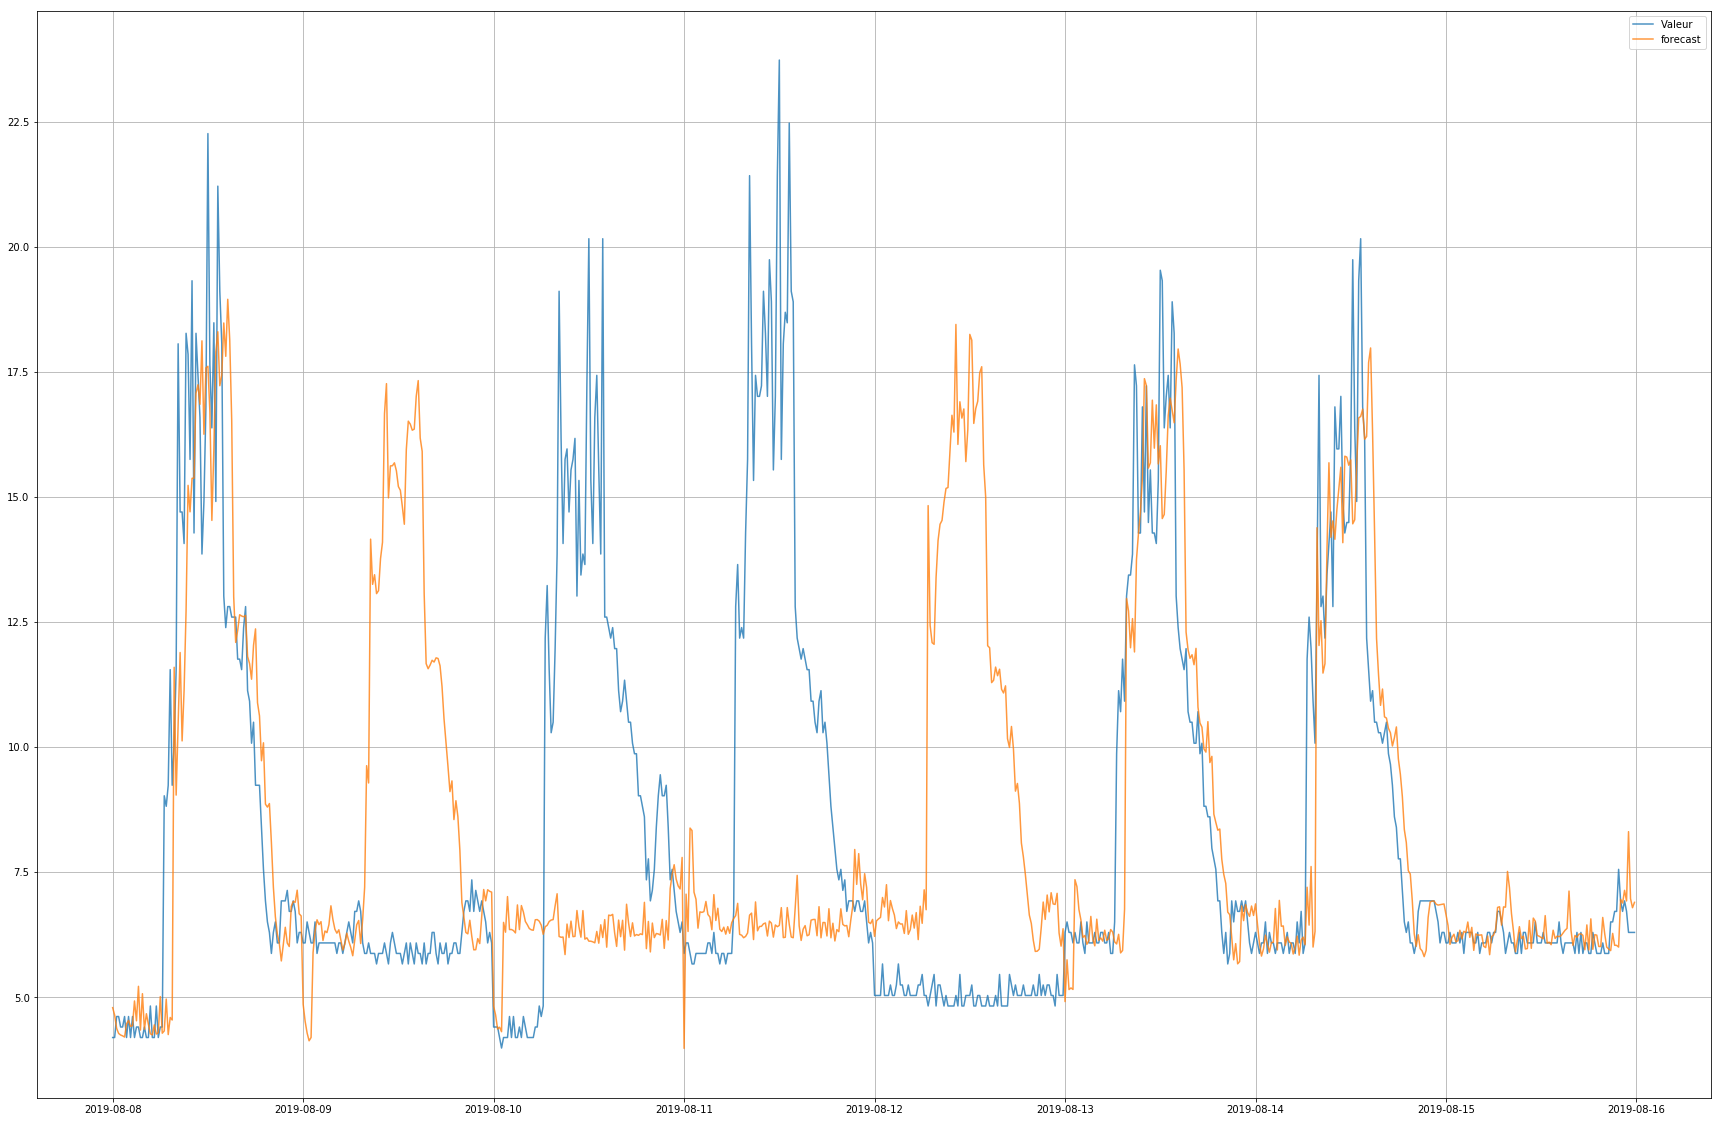

,Valeur,Datetime,forecast
Date,,,
2019-01-09 00:00:00,6.93,2019-01-09 00:00:00,7.500196
2019-01-09 00:15:00,6.51,2019-01-09 00:15:00,6.942563
2019-01-09 00:30:00,6.30,2019-01-09 00:30:00,6.740320
2019-01-09 00:45:00,6.51,2019-01-09 00:45:00,6.342435
2019-01-09 01:00:00,6.30,2019-01-09 01:00:00,6.353085
2019-01-09 01:15:00,6.51,2019-01-09 01:15:00,6.383048
2019-01-09 01:30:00,6.93,2019-01-09 01:30:00,6.399415
2019-01-09 01:45:00,6.51,2019-01-09 01:45:00,6.629622
2019-01-09 02:00:00,6.72,2019-01-09 02:00:00,6.598564


In [220]:
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc['2019-08-01':'2019-08-15'],label=dtype,alpha=0.8)
    #plt.plot('Datetime',dtype,data=fc[:'2019-02-01'],label=dtype,alpha=0.8)
plt.legend()
plt.grid()
plt.rcParams.update({'figure.figsize': (30,20)})
plt.show()
fc[:'2019-08-15']

In [196]:
from datetime import date
import calendar
fc['day of week'] = fc.index.dayofweek
fc['day of week'] = fc['Datetime'].apply(lambda x: x.strftime('%a'))
fc['2019-07-09']

,Valeur,Datetime,forecast,day of week
Date,,,,
2019-07-09 00:00:00,6.09,2019-07-09 00:00:00,7.513157,Tue
2019-07-09 00:15:00,6.30,2019-07-09 00:15:00,6.947563,Tue
2019-07-09 00:30:00,6.51,2019-07-09 00:30:00,6.169819,Tue
2019-07-09 00:45:00,6.09,2019-07-09 00:45:00,6.052136,Tue
2019-07-09 01:00:00,6.09,2019-07-09 01:00:00,6.354611,Tue
2019-07-09 01:15:00,5.88,2019-07-09 01:15:00,4.876019,Tue
2019-07-09 01:30:00,6.30,2019-07-09 01:30:00,4.452108,Tue
2019-07-09 01:45:00,6.30,2019-07-09 01:45:00,4.414568,Tue
2019-07-09 02:00:00,6.09,2019-07-09 02:00:00,4.115146,Tue


In [134]:
expected = fc['Valeur']
predictions = fc['forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
#print('Forecast Errors: %s' % forecast_errors)
bias = sum(forecast_errors) * 1.0/len(expected)
print('Bias: %f [kWh]' % bias)

Bias: -0.151030 [kWh]


In [137]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected, predictions)
print('MAE: %f [kWh]' % mae)

MAE: 2.286449 [kWh]


In [138]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected, predictions)
print('MSE: %f [kWh^2]' % mse)

MSE: 16.527169 [kWh^2]


In [140]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f [kWh]' % rmse)

RMSE: 4.065362 [kWh]


In [181]:
#from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(np.array(expected), np.array(predictions))

35.18603258039485

In [182]:
np.array([3,5,2]) - np.array([1,1,1])

array([2, 4, 1])

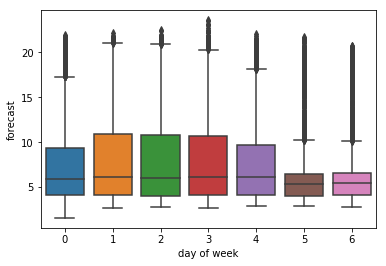

In [183]:
fc.head()
sns.boxplot(x='day of week', y='forecast', data=fc)